# **Testing for Stuctural Breaks in Time Series Data with a Chow Test**

## **I. Introduction**

I've written a bit on forecasting future stock prices and distributions of future stock prices. I'm proud of the models I built for those articles, but they will eventually be no more predictive than a monkey throwing darts at a board. Perhaps they'll perform worse.

This will happen because the underlying system, of which we are modeling an aspect, will change. For an extreme example, a company whose stock we are trying to model goes out of business. The time series just ends. For a more subtle example, let's look at the relationship between oil prices and dollar exchange rates.

I took historical real USD exchange rates measured against a broad basket of currencies and oil prices (WTI) going from January 1986 to February 2019 and indexed them to January 2000. I then took the natural logarithm of each, because this would give us the growth rate if we differenced the data and is a common transformation with time series data (and for dealing with skewed variables in non-time series analysis).

As you can see, they appear inversely related over time. When one goes up, the other goes down. This makes sense because when people outside the US want to buy oil, they often need to use USD for the transaction. Oil prices rise and they need to exchange more of their domestic currency to buy the same amount. This in turn strengthens the dollar and the exchange rate goes down as demand for USD increases and supply of foreign currencies increase. (An exchange rate of 1 means it takes 1 USD to buy 1 unit of foreign currency. If it is 2, it takes 2 USD to buy 1 unit of foreign currency. If it is 0.5, 1 USD buys 2 units of the foreign currency).

But, does the inverse relationship remain constant over time? Are there periods where a movement in one corresponds to a larger movement in the other relative to other times? This type of change in the relationship between oil prices and USD exchange rates could occur for a variety of reasons. For example, a major currency crisis across a region driving up demand for safe USD, while reducing demand for oil as the economy weakens. Perhaps a bunch of currencies disappear and one major one forms as the countries join a monetary union, like the EU.

C:\Users\jkcle\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


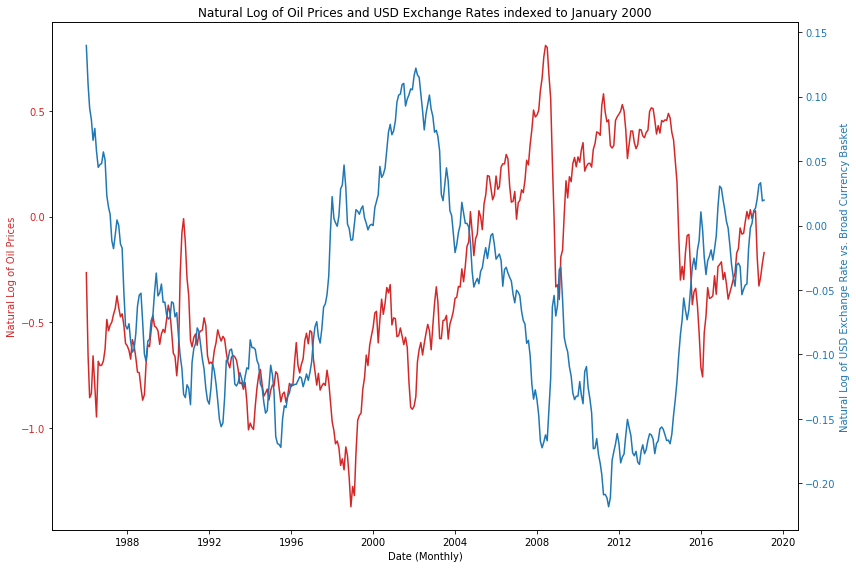

In [1]:
# for linear algebra and mathematical functions
import numpy as np
# for dataframe manipulation
import pandas as pd
# for data visualization
import matplotlib.pyplot as plt
# for setting plot size
import matplotlib as mpl
# for changing the plot size in the Jupyter Notebook output
%matplotlib inline
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# reads in data on historical oil prices and dollar exchange rates
full_data = pd.read_csv('Oil Data.csv')

# generates a variable for the growth rate of the Real Trade Weighted U.S. Dollar Index: 
# Broad, Goods indexed to January 2000
index_value = float(full_data.loc[full_data.Date == '01-2000']['TWEXBPA'].values)
full_data['broad_r'] = list(full_data.TWEXBPA / index_value)
full_data['ebroad_r'] = np.log(full_data.broad_r)

# generates a variable for the growth rate of the Real Trade Weighted U.S. Dollar Index: 
# Major Currencies, Goods indexed to January 2000
index_value = float(full_data.loc[full_data.Date == '01-2000']['TWEXMPA'].values)
full_data['major_r'] = list(full_data.TWEXMPA / index_value)
full_data['emajor_r'] = np.log(full_data.major_r)

# generates a variable for the growth rate of the Real Trade Weighted U.S. Dollar Index: 
# Other Important Trading Partners, Goods indexed to January 2000
index_value = float(full_data.loc[full_data.Date == '01-2000']['TWEXOPA'].values)
full_data['oitp_r'] = list(full_data.TWEXOPA / index_value)
full_data['eoitp_r'] = np.log(full_data.oitp_r)

# generates a variable for the growth rate of Crude Oil Prices: West Texas Intermediate 
# (WTI) - Cushing, Oklahoma indexed to January 2000
index_value = float(full_data.loc[full_data.Date == '01-2000']['MCOILWTICO'].values)
# adjusts for inflation prior to indexing to January 2000
full_data['po_r'] = full_data.MCOILWTICO / (full_data.Fred_CPIAUCNS / 100) / index_value
full_data['epo_r'] = np.log(full_data.po_r)

# creates a column for month
full_data.Date = pd.to_datetime(full_data.Date)
full_data['month'] = full_data.Date.map(lambda x: x.month)

# creates a list of all the variables of interest
variables_to_keep = ['epo_r', 'Date', 'month', 'ebroad_r', 'emajor_r', 'eoitp_r']

# creates a new dataframe containing only the variables of interest
my_data = full_data[variables_to_keep]

# creates dummy variables for each month, dropping January to avoid multicollinearity
my_data =  pd.concat([my_data, pd.get_dummies(my_data.month, drop_first = True)], axis = 1)

# sets the Date as the index
my_data.index = pd.DatetimeIndex(my_data.Date)

# drops these columns for a tidy data set
my_data = my_data.drop(['month', 'Date'], axis = 1)


# the code below plots the real oil price growth rate with the USD vs Broad Currency Basket
# exchange growth rate

# Create some mock data
time = my_data.index
epo_r = my_data.epo_r
ebroad_r = my_data.ebroad_r

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date (Monthly)')
ax1.set_ylabel('Natural Log of Oil Prices', color = color)
ax1.plot(time, epo_r, color=color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Natural Log of USD Exchange Rate vs. Broad Currency Basket', 
               color = color)  # we already handled the x-label with ax1
ax2.plot(time, ebroad_r, color = color)
ax2.tick_params(axis = 'y', labelcolor = color)

plt.title('Natural Log of Oil Prices and USD Exchange Rates indexed to January 2000')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## **II. Detecting a Suspected Break at a Known Date: The Chow Test**

The Chow Test tests if the true coefficients in two different regression models are equal. The null hypothesis is they are equal and the alternative hypothesis is they are not. Another way of saying this is that the null hypothesis is the model before the possible break point is the same as the model after the possible break point. The alternative hypothesis is the model fitting each periods are different.

It formally tests this by performing an F-test on the Chow Statistic which is (RSS_pooled - (RSS1 + RSS2))/(number of independent variables plus 1 for the constant) divided by (RSS1 + RSS2)/(Number of observations in subsample 1 + Number of observations in subsample 2 - 2*(number of independent variables plus 1 for the constant).

The models in each of the models (pooled, 1, 2) must have normally distributed error with mean 0, as well as independent and identically distributed errors, to satisfy the Gauss-Markov assumptions.

I use the Chow test to test for a structural break at the introduction of the Euro in January 1999. This seems a reasonable possible structural break, because a handful of major currencies, and some minor ones, disappeared and a new very important currency was created. The creation of the Euro certainly qualifies as a major shock to currency markets and perhaps to the oil vs. dollar relationship.

In [2]:
#imports the chowtest package as ct, which is written by yours truly
import chowtest as ct

Translating the independently and identically distributed residual requirement to English translates as constant mean and variance without serial correlation in the residuals. To test for this, I tested for auto-correlation and heteroskedasticity in my residuals. I did the same tests on their growth rates (the difference in natural logs). I also plotted the residuals and estimated their mean.

The auto-correlation function plots strongly suggest that the residuals from the simple OLS model have strong auto-correlation, while the residuals from the OLS of the growth rates are not auto-correlated.

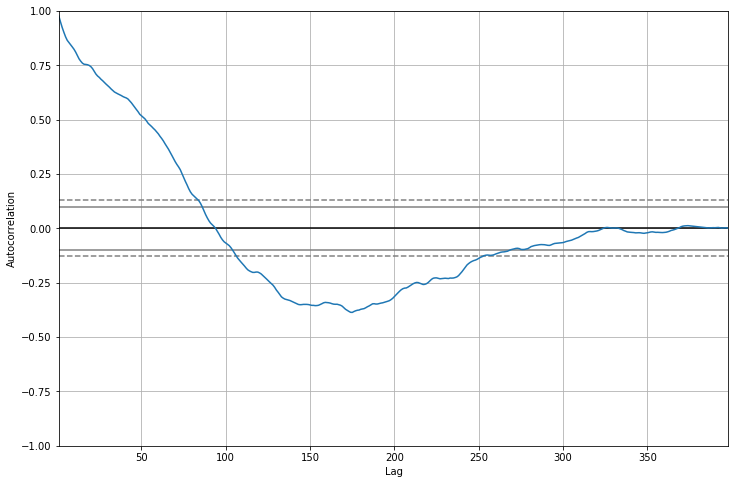

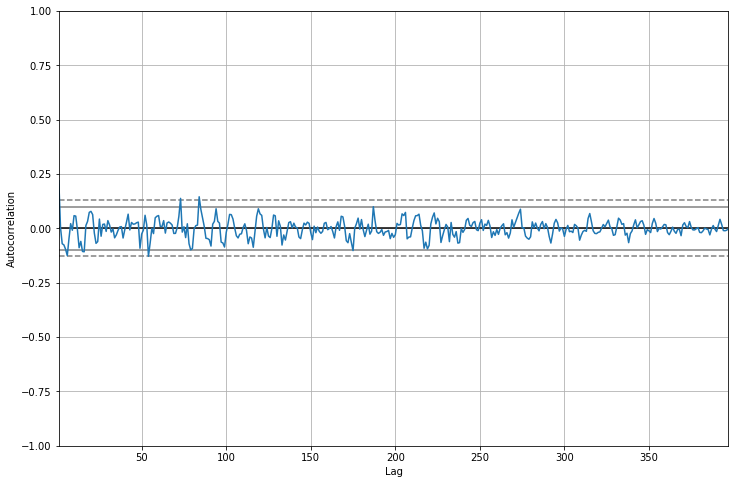

In [3]:
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# to reduce typing, I saved ebroad_r as X and epo_r as y
X = pd.DataFrame(my_data[['emajor_r', 'eoitp_r']])
y = pd.DataFrame(my_data.epo_r)
# to reduce typing, I saved the differenced ebroad_r as X_diff and epo_r as y_diff
X_diff = X.diff().dropna()
y_diff = y.diff().dropna()

# saves the residuals from the undifferenced X and y OLS model
un_diffed_resids = ct.linear_residuals(X, y).residuals

# saves the residuals from the differenced X and y OLS model
diffed_resids = ct.linear_residuals(X_diff, y_diff).residuals

# plots the ACF for the residuals of the OLS  regression of epo_r on ebroad_r
pd.plotting.autocorrelation_plot(un_diffed_resids)
plt.show()

# plots the ACF for the residuals of the OLS regression of the differenced epo_r on 
# differenced ebroad_r
pd.plotting.autocorrelation_plot(diffed_resids)
plt.show()

The Breusch-Pagan Test shows that heteroskedasticity is present in the OLS model. It is also present in the model of growth rates, but is much less severe.

In [4]:
from statsmodels.stats.diagnostic import het_breuschpagan

# tests for heteroskedasticity in the full-sample residuals
print('F-statistic for the Breusch-Pagan Test the OLS model: ' + 
      str(het_breuschpagan(un_diffed_resids, X)[2]))
print('p-value for the Breusch-Pagan F-Test the OLS model: ' + 
      str(het_breuschpagan(un_diffed_resids, X)[3]))


# tests for heteroskedasticity in the full-sample residuals
print('F-statistic for the Breusch-Pagan Test the growth rate OLS model: ' + 
      str(het_breuschpagan(diffed_resids, X_diff)[2]))
print('p-value for the Breusch-Pagan R-Test the growth rate OLS model: ' + 
      str(het_breuschpagan(diffed_resids, X_diff)[3]))

F-statistic for the Breusch-Pagan Test the OLS model: 139.55507258456245
p-value for the Breusch-Pagan F-Test the OLS model: 1.3411248465224378e-46
F-statistic for the Breusch-Pagan Test the growth rate OLS model: 4.335645337938573
p-value for the Breusch-Pagan R-Test the growth rate OLS model: 0.013722188948680505


The histograms of residuals show a bell-curve shape to the residuals of the OLS model looking at growth rates. The histogram of residuals for the regular OLS model show a possibly double-humped shape.

(array([ 9., 41., 41., 32., 38., 63., 59., 81., 25.,  9.]),
 array([-0.9452041 , -0.76481149, -0.58441889, -0.40402628, -0.22363367,
        -0.04324107,  0.13715154,  0.31754415,  0.49793675,  0.67832936,
         0.85872196]),
 <a list of 10 Patch objects>)

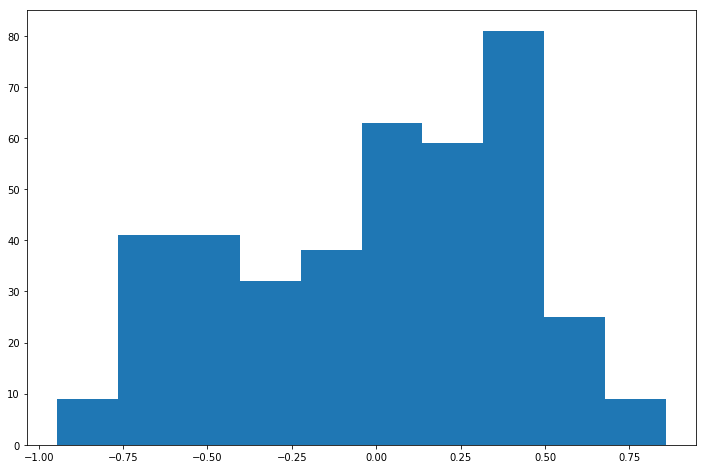

In [5]:
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)
                                          
# plots the histogram of residuals
plt.hist(un_diffed_resids)

(array([  2.,   0.,   8.,  23.,  84., 172.,  92.,  12.,   3.,   1.]),
 array([-0.42765525, -0.3487868 , -0.26991834, -0.19104988, -0.11218142,
        -0.03331297,  0.04555549,  0.12442395,  0.2032924 ,  0.28216086,
         0.36102932]),
 <a list of 10 Patch objects>)

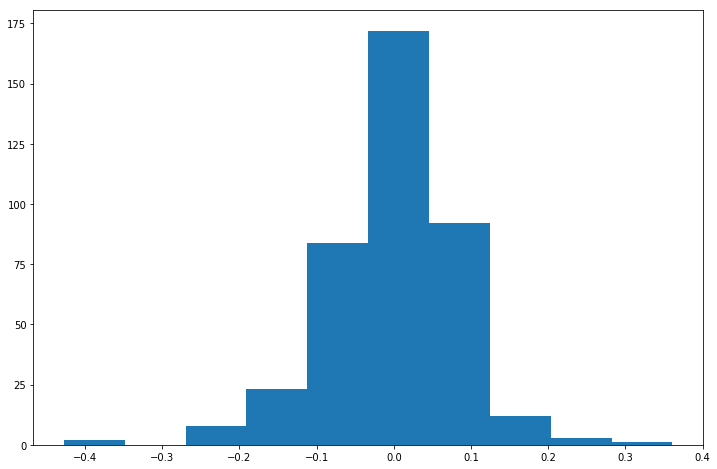

In [6]:
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)
                                          
# plots the histogram of residuals
plt.hist(diffed_resids)

The normality tests for the residuals from each model are both failures.

In [7]:
# imports the normality test from scipy.stats
from scipy.stats import normaltest

# performs the normality test on the residuals from the non-differenced OLS model
print(normaltest(un_diffed_resids))
# performs the normality test on the residuals from the differenced OLS model
print(normaltest(diffed_resids))

NormaltestResult(statistic=76.18184574530885, pvalue=2.866304897967838e-17)
NormaltestResult(statistic=49.549554396332184, pvalue=1.7396063026293013e-11)


Despite failing the normality tests, the mean of the residuals of both models are essentially 0. The model of growth rates has residuals that are are independently distributed and bell-shaped based on the ACF plot, even though there is evidence of heteroskedasticity at the 0.05 significance level. For these reasons, I will proceed with my analysis using the growth rate model and assume my Chow Test result will be robust to the non-normality of residuals.

In [8]:
print('Mean of OLS residuals: ' + str(np.mean(un_diffed_resids)))
print('Mean of OLS model of growth rate residuals: ' + str(np.mean(diffed_resids)))

Mean of OLS residuals: 5.1605844109460794e-18
Mean of OLS model of growth rate residuals: 4.1947973222612966e-19


I come to the same conclusion for the models estimating before and after the split dates and proceed with the Chow Test.

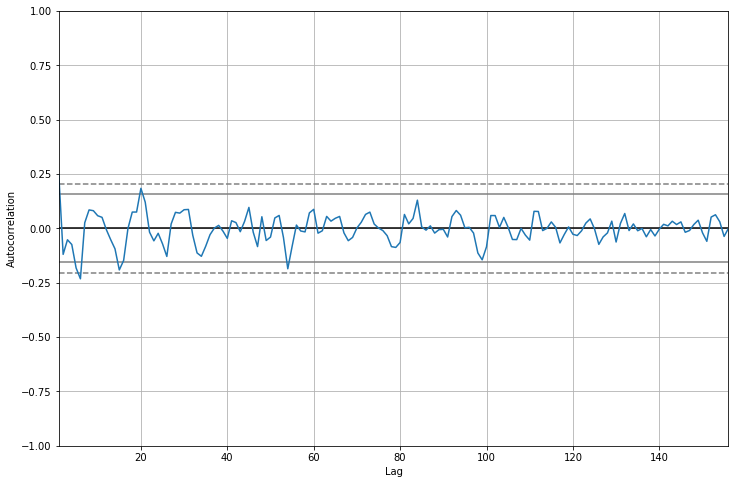

F-statistic for the Breusch-Pagan Test the growth rate OLS model: 6.566961971262655
p-value for the Breusch-Pagan F-Test the growth rate OLS model: 0.0018328231672312253
Mean of OLS model of growth rate residuals pre-Euro: -1.0675221390626506e-18


In [9]:
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# creates split dates for our sample period
stop = '1999-01-01'
start = '1999-02-01'

# plots the ACF for the residuals of the OLS regression of the differenced epo_r on 
# differenced ebroad_r
pd.plotting.autocorrelation_plot(ct.linear_residuals(X_diff.loc[:stop], 
                                                        y_diff.loc[:stop]).residuals)
plt.show()

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# tests for heteroskedasticity in the full-sample residuals
print('F-statistic for the Breusch-Pagan Test the growth rate OLS model: ' + 
      str(het_breuschpagan(ct.linear_residuals(X_diff.loc[:stop], 
                                                        y_diff.loc[:stop]).residuals, 
                           X_diff.loc[:stop])[2]))
print('p-value for the Breusch-Pagan F-Test the growth rate OLS model: ' + 
      str(het_breuschpagan(ct.linear_residuals(X_diff.loc[:stop], 
                                                        y_diff.loc[:stop]).residuals, 
                           X_diff.loc[:stop])[3]))

print('Mean of OLS model of growth rate residuals pre-Euro: ' + 
      str(np.mean(ct.linear_residuals(X_diff.loc[:stop], 
                                                        y_diff.loc[:stop]).residuals)))

<function matplotlib.pyplot.show(*args, **kw)>

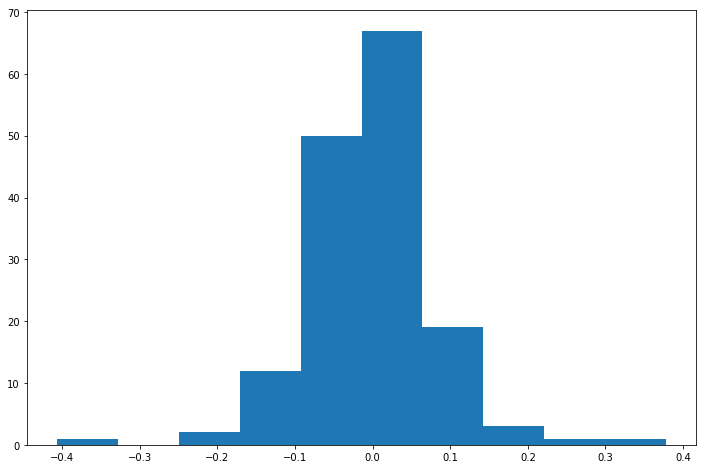

In [10]:
# plots the histogram of residuals
plt.hist(ct.linear_residuals(X_diff.loc[:stop], y_diff.loc[:stop]).residuals)
plt.show

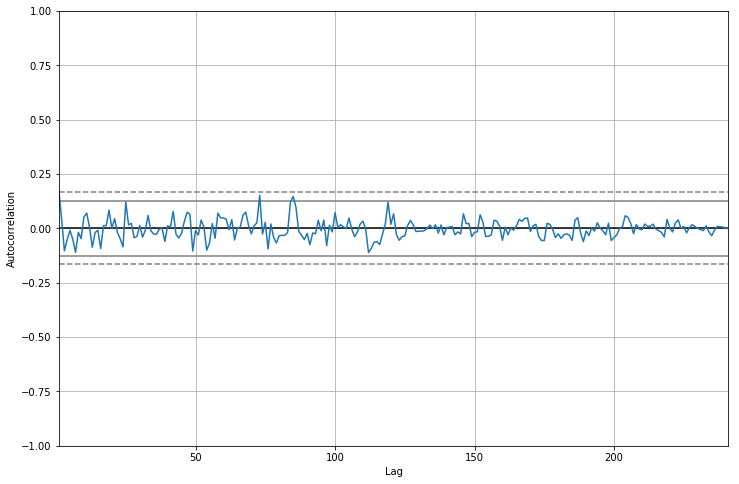

F-statistic for the Breusch-Pagan Test the growth rate OLS model: 1.3127612993566853
p-value for the Breusch-Pagan F-Test the growth rate OLS model: 0.27100905668047
Mean of OLS model of growth rate residuals pre-Euro: -2.0154463621307304e-18


In [11]:
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the ACF for the residuals of the OLS regression of the differenced epo_r on 
# differenced ebroad_r
pd.plotting.autocorrelation_plot(ct.linear_residuals(X_diff[start:], 
                                                        y_diff[start:]).residuals)
plt.show()

# tests for heteroskedasticity in the full-sample residuals
print('F-statistic for the Breusch-Pagan Test the growth rate OLS model: ' + 
      str(het_breuschpagan(ct.linear_residuals(X_diff.loc[start:], 
                                                        y_diff.loc[start:]).residuals, 
                           X_diff.loc[start:])[2]))
print('p-value for the Breusch-Pagan F-Test the growth rate OLS model: ' + 
      str(het_breuschpagan(ct.linear_residuals(X_diff.loc[start:], 
                                                        y_diff.loc[start:]).residuals, 
                           X_diff.loc[start:])[3]))

print('Mean of OLS model of growth rate residuals pre-Euro: ' + 
      str(np.mean(ct.linear_residuals(X_diff.loc[start:], 
                                                        y_diff.loc[start:]).residuals)))

(array([ 1.,  1.,  4.,  9., 25., 46., 79., 53., 19.,  4.]),
 array([-0.36248587, -0.30505357, -0.24762127, -0.19018896, -0.13275666,
        -0.07532435, -0.01789205,  0.03954025,  0.09697256,  0.15440486,
         0.21183717]),
 <a list of 10 Patch objects>)

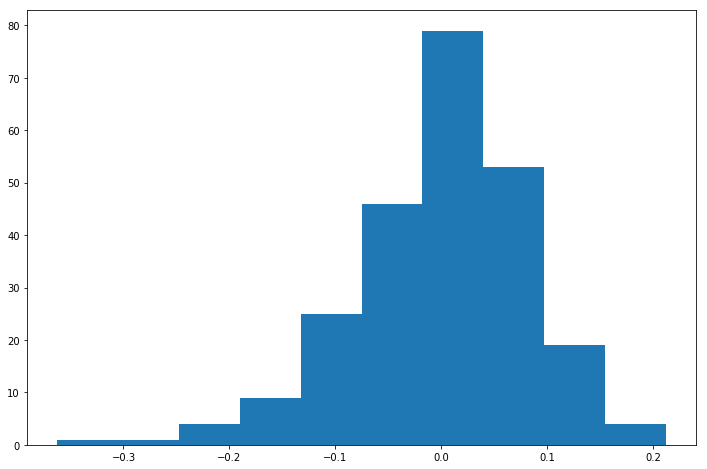

In [12]:
# plots the histogram of residuals
plt.hist(ct.linear_residuals(X_diff.loc[start:], y_diff.loc[start:]).residuals)

The result of the Chow Test is there is a 0.09% chance that the model before the introduction of the Euro is the same as the model after the introduction of the Euro, given the evidence. It is safe to say that the model of real oil price and dollar exchange growth rates is different pre-Euro and post-Euro introduction.

In [13]:
# performs the Chow Test
ct.ChowTest(X.diff().dropna(), y.diff().dropna(), stop, start)

(2.4206765246215887, 0.03526531195879279)